In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L3J1bi9tZWRpYS9hbGYvZGF0b3MvbWlzcmVwb3NpdG9yaW9zL2RvY2VuY2lhL2FwcmVuZGl6YWplLWF1dG9tYXRpY28tcHJhY3RpY2FzLWp1bGlh"
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
function fibonacci(n::Int)
    a = zeros(Float32, n)
    a[1] = 1
    a[2] = 1
    for i in 3:n
        a[i] = a[i-1] + a[i-2]
    end
    return a
end

fibonacci (generic function with 1 method)

In [3]:
fib = fibonacci(25) 
tamaño = 4
n = 25 - tamaño
# La red esperar una entrada con dimensiones (características, tamaño, lote).
X =  Array{Float32}(undef, 1, tamaño, n)
Y = Array{Float32}(undef, 1, n)  
for i = 1:n
    ventana = fib[i:i+tamaño-1]
    etiqueta = fib[i+tamaño]
    X[1, : , i] .= ventana
    Y[1, i] = etiqueta
end

In [4]:
using Lux, Random

modelo = Chain(
    Recurrence(RNNCell(1 => 1, identity; use_bias = false); return_sequence = false)
)

rng = Random.default_rng()
# Semilla aleatoria para reproducibilidad
Random.seed!(rng, 1234)
ps, st = Lux.setup(rng, modelo)

((layer_1 = (weight_ih = Float32[-1.7194579;;], weight_hh = Float32[1.174417;;]),), (layer_1 = (rng = TaskLocalRNG(),),))

In [5]:
using Statistics
function coste(ps, st, X, Y)
    ŷ, estado = modelo(X, ps, st)          # ŷ: (1, batch)
    return mean((ŷ .- Y).^2)
end

coste(ps, st, X, Y)

6.2632223f9

In [6]:
using Optimisers, Zygote
opt = Optimisers.setup(Optimisers.Adam(0.1f0), ps)

nepocas = 200
costes = []
for epoca in 1:nepocas
    # gradiente de la red con respecto a los parámetros
    gs = first(Zygote.gradient(p -> coste(p, st, X, Y), ps))
    opt, ps = Optimisers.update(opt, ps, gs) 
    push!(costes, coste(ps, st, X, Y))
    println("Época $epoca | coste = ", costes[end])
end

Época 1 | coste = 5.0130447e9


Época 2 | coste = 4.046983e9
Época 3 | coste = 3.3034327e9
Época 4 | coste = 2.7312077e9
Época 5 | coste = 2.2893059e9
Época 6 | coste = 1.94581e9
Época 7 | coste = 1.6764061e9
Época 8 | coste = 1.4628404e9
Época 9 | coste = 1.2915259e9
Época 10 | coste = 1.1523862e9
Época 11 | coste = 1.0379493e9
Época 12 | coste = 9.4265696e8
Época 13 | coste = 8.623539e8
Época 14 | coste = 7.9391226e8
Época 15 | coste = 7.349589e8
Época 16 | coste = 6.836777e8
Época 17 | coste = 6.386652e8
Época 18 | coste = 5.9882643e8
Época 19 | coste = 5.632986e8
Época 20 | coste = 5.313949e8
Época 21 | coste = 5.0256346e8
Época 22 | coste = 4.7635606e8
Época 23 | coste = 4.5240582e8
Época 24 | coste = 4.3040934e8
Época 25 | coste = 4.101142e8
Época 26 | coste = 3.913082e8
Época 27 | coste = 3.7381197e8
Época 28 | coste = 3.5747312e8
Época 29 | coste = 3.4216106e8
Época 30 | coste = 3.277637e8
Época 31 | coste = 3.141841e8
Época 32 | coste = 3.0133814e8
Época 33 | coste = 2.891527e8
Época 34 | coste = 2.77564e8


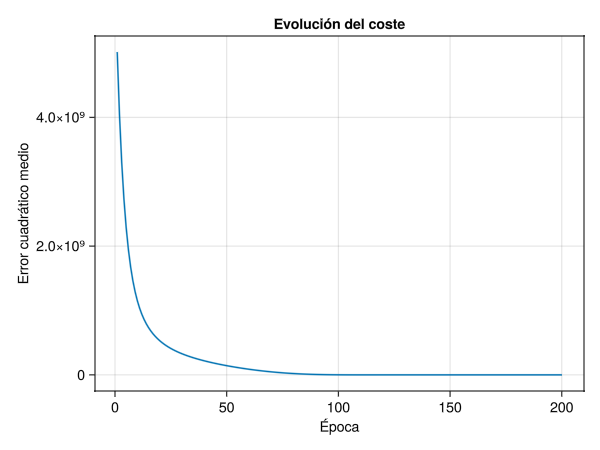

In [7]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Época", ylabel = "Error cuadrático medio", title = "Evolución del coste")
lines!(ax, costes)
fig

In [8]:
fib = fibonacci(30)
X_test = reshape(fib[end-tamaño : end-1], 1, tamaño, 1) 

y_test, _ = modelo(X_test, ps, st)
println("Predicción del término 30: ",  y_test[1, 1])
println("Término 30 de la sucesión de Fibonacci: ", fib[end])

Predicción del término 30: 831997.2
Término 30 de la sucesión de Fibonacci: 832040.0


In [9]:
println("Pesos de la entrada de la red neuronal:", ps.layer_1.weight_ih)
println("Pesos del estado de la red neuronal:", ps.layer_1.weight_hh)

Pesos de la entrada de la red neuronal:Float32[1.662782;;]
Pesos del estado de la red neuronal:Float32[-0.04483252;;]


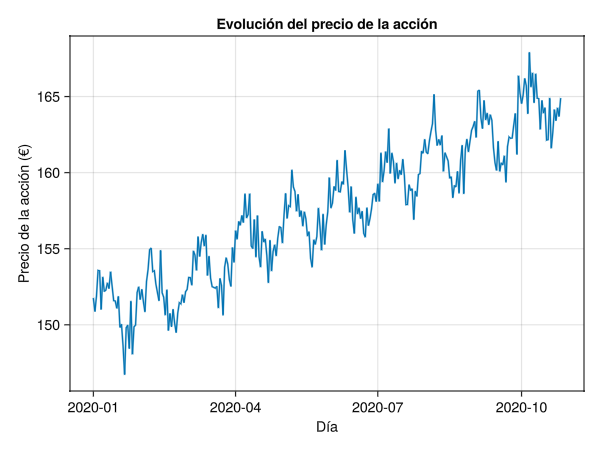

In [10]:
using CSV, DataFrames, GLMakie

# Cargamos el conjunto de datos en un data frame
df = CSV.read("datos/stock.csv", DataFrame)

# Creamos el gráfico de la evolución
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Día", ylabel = "Precio de la acción (€)", title = "Evolución del precio de la acción")

lines!(ax, df.dia, df.precio)
fig

In [11]:
using Statistics

# Simple normalization (z-score)
μ = mean(df.precio)
σ = std(df.precio)
serie = (df.precio .- μ) ./ σ     

300-element Vector{Float64}:
 -1.2770239698472932
 -1.4749432268197025
 -1.2481144154580652
 -0.8745140202741842
 -0.8789616440263692
 -1.4460336724304748
 -0.9679141190701513
 -1.1814000591752272
 -1.1591619404142832
 -1.054642782237841
 -1.1391476335294317
 -0.8923045152829369
 -1.1035666435119202
  ⋮
  1.4249074596075517
  1.5049646871469575
  1.031292757538819
  1.0379641931671029
  1.6472886472170039
  0.9112069162297167
  1.1469309750957366
  1.4782789446338223
  1.3137168658028255
  1.5027408752708586
  1.3759835983334725
  1.6450648353409114

In [12]:
function crear_secuencias(serie, tamaño)
    # Número de ventanas
    n = length(serie) - tamaño  

    # X: (características=1, tamaño=seq_len, lotes=n)
    X = Array{Float32}(undef, 1, tamaño, n)
    # Y: (etiquetas=1, lotes=n)
    Y = Array{Float32}(undef, 1, n)

    for i in 1:n
        ventana = serie[i : i + tamaño - 1]
        etiqueta = serie[i + tamaño]
        X[1, :, i] .= ventana
        Y[1, i] = etiqueta
    end

    return X, Y
end

X, Y = crear_secuencias(serie, 50)

(Float32[-1.2770239 -1.4749433 … -1.7551435 -1.501629;;; -1.4749433 -1.2481145 … -1.501629 -1.6973244;;; -1.2481145 -0.87451404 … -1.6973244 -1.4393623;;; … ;;; 1.7607031 1.3515216 … 1.478279 1.3137169;;; 1.3515216 1.1980786 … 1.3137169 1.5027409;;; 1.1980786 1.6117077 … 1.5027409 1.3759836], Float32[-1.6973244 -1.4393623 … 1.3759836 1.6450648])

In [13]:
Xentrenamiento, Yentrenamiento = X[:, :, 1:200], Y[:, 1:200]
Xtest, Ytest = X[:, :, 201:end], Y[:, 201:end]

(Float32[0.08839652 0.09062033 … 1.3515216 1.1980786;;; 0.09062033 0.3797159 … 1.1980786 1.6117077;;; 0.3797159 0.29298723 … 1.6117077 1.3248359;;; … ;;; 1.7607031 1.3515216 … 1.478279 1.3137169;;; 1.3515216 1.1980786 … 1.3137169 1.5027409;;; 1.1980786 1.6117077 … 1.5027409 1.3759836], Float32[1.6117077 1.3248359 … 1.3759836 1.6450648])

In [14]:
using Lux, Random
modelo = Chain(
    Recurrence(GRUCell(1 => 32); return_sequence = false),
    Dense(32 => 1)
)

rng = Random.default_rng()
# Semilla aletoria para reproducibilidad
Random.seed!(rng, 1234)
ps, st = Lux.setup(rng, modelo)

((layer_1 = (weight_ih = Float32[-0.2854142; 0.068106644; … ; -0.19067948; 0.112374;;], weight_hh = Float32[-0.16169676 0.30161932 … 0.2332222 0.27419686; 0.283216 -0.14921711 … -0.13761395 0.023605108; … ; 0.10773007 -0.12217058 … -0.1603152 -0.06496244; -0.120453686 0.11889523 … -0.26631752 0.046838135], bias_ih = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], bias_hh = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = (weight = Float32[-0.108431235 0.12328395 … 0.21434428 0.24499455], bias = Float32[-0.091361046])), (layer_1 = (rng = TaskLocalRNG(),), layer_2 = NamedTuple()))

In [15]:
using Statistics
function coste(ps, st, X, Y)
    ŷ, estado = modelo(X, ps, st)
    return mean((ŷ .- Y).^2)
end

coste(ps, st, X, Y)

0.426244f0

In [16]:
using Optimisers, Zygote
opt = Optimisers.setup(Optimisers.Adam(0.01f0), ps)

nepocas = 300
costes = []
for epoca in 1:nepocas
    # gradiente de la red con respecto a los parámetros
    gs = first(Zygote.gradient(p -> coste(p, st, Xentrenamiento, Yentrenamiento), ps))
    opt, ps = Optimisers.update(opt, ps, gs) 
    push!(costes, coste(ps, st, Xentrenamiento, Yentrenamiento))
    println("Época $epoca | coste = ", costes[end])
end

Época 1 | coste = 0.113830455


Época 2 | coste = 0.12900627
Época 3 | coste = 0.14780147
Época 4 | coste = 0.117674865
Época 5 | coste = 0.08996766
Época 6 | coste = 0.07990036
Época 7 | coste = 0.081874885


Época 8 | coste = 0.08674451
Época 9 | coste = 0.088736184
Época 10 | coste = 

0.086316384
Época 11 | coste = 0.08088959


Época 12 | coste = 0.075109884
Época 13 | coste = 0.07141426
Época 14 | coste = 0.070892625
Época 15 | coste = 0.072734214
Época 16 | coste = 0.07484901
Época 17 | coste = 0.075510785
Época 18 | coste = 

0.07440865
Época 19 | coste = 0.072338395
Época 20 | coste = 0.07037811
Época 21 | coste = 0.069285996
Época 22 | coste = 0.06926064
Época 23 | coste = 0.06999929
Época 24 | coste = 0.07092417
Época 25 | coste = 0.07146476


Época 26 | coste = 

0.071321055
Época 27 | coste = 0.07058905
Época 28 | coste = 0.069666125
Época 29 | coste = 0.069001935
Época 30 | coste = 0.06884281
Época 31 | coste = 0.069114
Época 32 | coste = 0.06951342
Época 33 | coste = 0.069738224
Época 34 | coste = 

0.06965728
Época 35 | coste = 0.06932886
Época 36 | coste = 0.068914026
Época 37 | coste = 0.068580136
Época 38 | coste = 0.068433985
Época 39 | coste = 0.06848134
Época 40 | coste = 

0.068623684
Época 41 | coste = 0.068713285
Época 42 | coste = 0.06864739
Época 43 | coste = 0.068434425
Época 44 | coste = 0.06817779
Época 45 | coste = 0.06799273
Época 46 | coste = 

0.06792634
Época 47 | coste = 0.06794021


Época 48 | coste = 0.067955166
Época 49 | coste = 0.0679099
Época 50 | coste = 0.067791104
Época 51 | coste = 0.06762927
Época 52 | coste = 0.067475036
Época 53 | coste = 0.06736941
Época 54 | coste = 

0.067318514
Época 55 | coste = 0.06728885
Época 56 | coste = 0.06723132
Época 57 | coste = 0.06711916
Época 58 | coste = 0.06696776
Época 59 | coste = 0.066817924
Época 60 | coste = 0.06669793
Época 61 | coste = 0.0666003
Época 62 | coste = 

0.066492155
Época 63 | coste = 0.06634506
Época 64 | coste = 0.06615466
Época 65 | coste = 0.065937094
Época 66 | coste = 0.065709636
Época 67 | coste = 0.06547125
Época 68 | coste = 0.06519644
Época 69 | coste = 0.06484923


Época 70 | coste = 0.06440709
Época 71 | coste = 0.06386954
Época 72 | coste = 0.06323773
Época 73 | coste = 0.062491756
Época 74 | coste = 0.061626706
Época 75 | coste = 0.060717784
Época 76 | coste = 

0.059877597
Época 77 | coste = 0.05928292
Época 78 | coste = 0.05876413
Época 79 | coste = 0.057971865
Época 80 | coste = 0.056798078
Época 81 | coste = 0.055793434
Época 82 | coste = 

0.05529263
Época 83 | coste = 0.055004157
Época 84 | coste = 0.05448219
Época 85 | coste = 0.05360001
Época 86 | coste = 0.05248977
Época 87 | coste = 0.05168814
Época 88 | coste = 0.05121798
Época 89 | coste = 0.05041036
Época 90 | coste = 

0.049369827
Época 91 | coste = 0.048880883
Época 92 | coste = 0.048822332
Época 93 | coste = 0.04953988
Época 94 | coste = 0.052644424
Época 95 | coste = 0.051890675
Época 96 | coste = 0.049517203
Época 97 | coste = 0.050142895


Época 98 | coste = 0.047301475
Época 99 | coste = 0.04991633
Época 100 | coste = 0.046925377
Época 101 | coste = 0.048548922
Época 102 | coste = 0.046865135
Época 103 | coste = 0.047150154
Época 104 | coste = 0.0472323
Época 105 | coste = 0.04659357


Época 106 | coste = 0.046270087
Época 107 | coste = 0.045697406
Época 108 | coste = 0.045982394
Época 109 | coste = 0.044973318
Época 110 | coste = 0.045416765
Época 111 | coste = 0.044620536
Época 112 | coste = 

0.04456389
Época 113 | coste = 0.04445027
Época 114 | coste = 0.044086494
Época 115 | coste = 0.04378073
Época 116 | coste = 0.043837056
Época 117 | coste = 0.043382503
Época 118 | coste = 0.043166447
Época 119 | coste = 0.042842068


Época 120 | coste = 0.042623457
Época 121 | coste = 0.042422075
Época 122 | coste = 0.042245418
Época 123 | coste = 0.041847568
Época 124 | coste = 0.04163301
Época 125 | coste = 0.04152428
Época 126 | coste = 

0.04120002
Época 127 | coste = 0.04082157
Época 128 | coste = 0.040488392
Época 129 | coste = 0.04022782
Época 130 | coste = 0.040299945
Época 131 | coste = 0.04125361
Época 132 | coste = 0.04541727
Época 133 | coste = 0.05584068


Época 134 | coste = 0.042757317
Época 135 | coste = 0.047936197
Época 136 | coste = 0.049484286
Época 137 | coste = 0.04332793
Época 138 | coste = 0.047739103
Época 139 | coste = 0.040213976


Época 140 | coste = 

0.04667796
Época 141 | coste = 0.04208882
Época 142 | coste = 0.042667683
Época 143 | coste = 0.04144386
Época 144 | coste = 0.042877264
Época 145 | coste = 0.0399141
Época 146 | coste = 0.041514773
Época 147 | coste = 0.04087246
Época 148 | coste = 

0.039948925
Época 149 | coste = 0.03989128
Época 150 | coste = 0.040043563
Época 151 | coste = 0.039563157
Época 152 | coste = 

0.03879453
Época 153 | coste = 0.03967904
Época 154 | coste = 0.038783297
Época 155 | coste = 0.038542088
Época 156 | coste = 0.03810814
Época 157 | coste = 0.038329225
Época 158 | coste = 

0.037560314
Época 159 | coste = 0.037756637
Época 160 | coste = 0.037197106
Época 161 | coste = 0.037287824
Época 162 | coste = 0.036864456
Época 163 | coste = 0.03671203
Época 164 | coste = 0.036420688
Época 165 | coste = 0.03623613


Época 166 | coste = 0.035772692
Época 167 | coste = 0.035813235
Época 168 | coste = 0.035447247
Época 169 | coste = 0.03517496
Época 170 | coste = 0.03509218
Época 171 | coste = 0.034656633
Época 172 | coste = 0.034433905
Época 173 | coste = 0.03424125


Época 174 | coste = 0.033835698
Época 175 | coste = 0.033467595
Época 176 | coste = 0.033234082
Época 177 | coste = 0.03303962
Época 178 | coste = 0.032698493
Época 179 | coste = 0.03246553
Época 180 | coste = 

0.03220095
Época 181 | coste = 0.032295458
Época 182 | coste = 0.033332676
Época 183 | coste = 0.03584316
Época 184 | coste = 0.04096717
Época 185 | coste = 0.037686516
Época 186 | coste = 0.03089538
Época 187 | coste = 0.032819334


Época 188 | coste = 0.0367148
Época 189 | coste = 0.03434424
Época 190 | coste = 0.029586181
Época 191 | coste = 0.033249125
Época 192 | coste = 0.03212678
Época 193 | coste = 0.029107936
Época 194 | coste = 

0.03321743
Época 195 | coste = 0.033298995
Época 196 | coste = 0.029658064
Época 197 | coste = 0.03173668
Época 198 | coste = 0.03029346
Época 199 | coste = 0.028980346
Época 200 | coste = 0.029403573
Época 201 | coste = 0.029416261


Época 202 | coste = 0.028935168
Época 203 | coste = 0.028737599
Época 204 | coste = 

0.028438758
Época 205 | coste = 0.033193782


Época 206 | coste = 0.02940547
Época 207 | coste = 0.02956583
Época 208 | coste = 0.03162155
Época 209 | coste = 0.027153788
Época 210 | coste = 0.030866425
Época 211 | coste = 0.032253124
Época 212 | coste = 0.03212175
Época 213 | coste = 0.029483207


Época 214 | coste = 0.02824005
Época 215 | coste = 0.033533465
Época 216 | coste = 0.027894363
Época 217 | coste = 0.030622732
Época 218 | coste = 0.029495386
Época 219 | coste = 0.030394608
Época 220 | coste = 0.028678406
Época 221 | coste = 0.027618866


Época 222 | coste = 0.027469644
Época 223 | coste = 0.02726527
Época 224 | coste = 0.026667014
Época 225 | coste = 0.026397815
Época 226 | coste = 0.026311476
Época 227 | coste = 0.025543053
Época 228 | coste = 0.025658472
Época 229 | coste = 0.02516052


Época 230 | coste = 0.02534998
Época 231 | coste = 0.024355724
Época 232 | coste = 0.024736883
Época 233 | coste = 0.023880932
Época 234 | coste = 0.02430721
Época 235 | coste = 0.023429463
Época 236 | coste = 0.023727886
Época 237 | coste = 0.02323434


Época 238 | coste = 0.023285935
Época 239 | coste = 0.022794904
Época 240 | coste = 0.022810597
Época 241 | coste = 0.022333233
Época 242 | coste = 0.022488128
Época 243 | coste = 0.021948032
Época 244 | coste = 

0.022168174
Época 245 | coste = 0.022284364
Época 246 | coste = 0.022310195
Época 247 | coste = 0.021476181
Época 248 | coste = 0.02174932
Época 249 | coste = 0.022552403
Época 250 | coste = 0.021382619
Época 251 | coste = 0.02113569


Época 252 | coste = 0.022732895
Época 253 | coste = 0.02400796
Época 254 | coste = 0.023314005
Época 255 | coste = 0.023779387
Época 256 | coste = 0.025597071
Época 257 | coste = 0.031135628
Época 258 | coste = 

0.032652587
Época 259 | coste = 0.023596633
Época 260 | coste = 0.025643118
Época 261 | coste = 0.02525381
Época 262 | coste = 0.025083944
Época 263 | coste = 0.028299427
Época 264 | coste = 0.02552618
Época 265 | coste = 0.0239337


Época 266 | coste = 0.026532
Época 267 | coste = 0.020955242
Época 268 | coste = 0.023672136
Época 269 | coste = 0.0203581
Época 270 | coste = 0.023516841
Época 271 | coste = 0.020028606
Época 272 | coste = 

0.021567024
Época 273 | coste = 0.021338262
Época 274 | coste = 0.020622712
Época 275 | coste = 0.020864582
Época 276 | coste = 0.020004738
Época 277 | coste = 0.020373816
Época 278 | coste = 0.019241646
Época 279 | coste = 0.020055369


Época 280 | coste = 0.01888778
Época 281 | coste = 0.018617202
Época 282 | coste = 

0.019198906
Época 283 | coste = 0.01803309
Época 284 | coste = 0.018291282
Época 285 | coste = 0.017833667
Época 286 | coste = 0.017835643
Época 287 | coste = 0.018332189
Época 288 | coste = 0.01781469
Época 289 | coste = 0.019024642
Época 290 | coste = 

0.019295808
Época 291 | coste = 0.021074545
Época 292 | coste = 0.022143818
Época 293 | coste = 0.02186691
Época 294 | coste = 0.01874483
Época 295 | coste = 0.016625697
Época 296 | coste = 0.017824085
Época 297 | coste = 0.020769177
Época 298 | coste = 

0.0216214
Época 299 | coste = 0.01764528
Época 300 | coste = 0.017135194


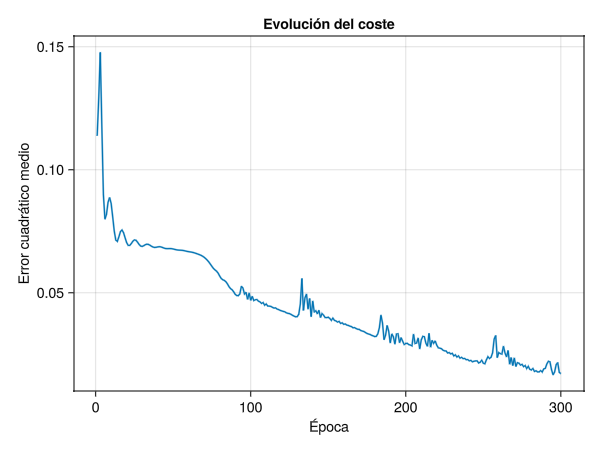

In [17]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Época", ylabel = "Error cuadrático medio", title = "Evolución del coste")
lines!(ax, costes)
fig

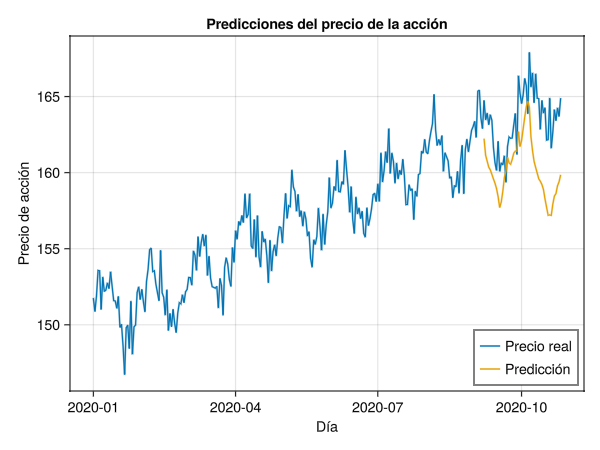

In [18]:
y_test, _ = modelo(Xtest, ps, st)
predicciones = y_test .* σ .+ μ

fig = Figure()
ax = Axis(fig[1,1], xlabel = "Día", ylabel = "Precio de acción", title = "Predicciones del precio de la acción")
lines!(ax, df.dia, df.precio, label = "Precio real")
lines!(ax, df.dia[251:end], vec(predicciones), label = "Predicción")
axislegend(ax, position = :rb)
fig